# Setup

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,timm,torchvision,io,PIL
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from fastcore.foundation import L

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

## Getting Features from VGG16

In [ ]:
timm.list_models('*vgg*')

['repvgg_a2',
 'repvgg_b0',
 'repvgg_b1',
 'repvgg_b1g4',
 'repvgg_b2',
 'repvgg_b2g4',
 'repvgg_b3',
 'repvgg_b3g4',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn']

In [ ]:
vgg16 = timm.create_model('vgg16', pretrained=True).features

In [ ]:
def features(imgs, target_layers=[18, 25]):
    device = imgs.device
    mean = torch.tensor([0.485, 0.456, 0.406])[:,None,None].to(device)
    std = torch.tensor([0.229, 0.224, 0.225])[:,None,None].to(device)
    x = (imgs-mean) / std
    feats = []
    for i, layer in enumerate(vgg16[:max(target_layers)+1]):
        x = layer(x)
        if i in target_layers: feats.append(x.clone())
    return feats

In [ ]:
def download_image(url):
    imgb = fc.urlread(url, decode=False) 
    return torchvision.io.decode_image(tensor(list(imgb), dtype=torch.uint8)).float()/255.

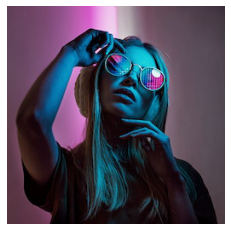

In [ ]:
url = "https://images.pexels.com/photos/2690323/pexels-photo-2690323.jpeg?w=256"
content_img = download_image(url)
show_image(content_img);

In [ ]:
content_img = content_img[None]
with torch.no_grad(): feats = features(content_img)
[f.shape for f in feats]

[torch.Size([1, 512, 32, 32]), torch.Size([1, 512, 16, 16])]

## Style Loss: Gram Matrix Version

Ask ChatGPT: In the context of style transfer, a gram matrix is a mathematical representation of the style of an image. It is typically used to measure the style similarity between two images, with a higher gram matrix similarity indicating a greater style similarity.

A gram matrix is calculated by taking the dot product of a matrix of the feature maps of a convolutional neural network (CNN) with itself. The feature maps are usually obtained from one of the hidden layers of the CNN, and they capture different aspects of the image content at different scales.

To calculate the gram matrix, the feature maps are first reshaped into a matrix, with the feature maps corresponding to different locations in the image being arranged in rows and the different feature maps being arranged in columns. The gram matrix is then obtained by taking the dot product of this matrix with itself.

The resulting gram matrix is a square matrix with dimensions equal to the number of feature maps. Each element of the gram matrix represents the dot product of a pair of feature maps, and the values of the elements capture the correlations between different feature maps.

In [ ]:
def styles(imgs):
    return L(torch.einsum('bchw, bdhw -> bcd', x, x) / (x.shape[-2]*x.shape[-1])
            for x in features(imgs, target_layers=[1, 6, 11, 18, 25]))

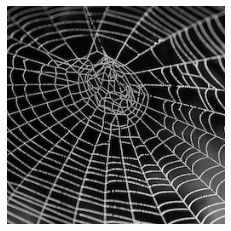

In [ ]:
url2 = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=384"
style_img = download_image(url2)[:,:256,:256]
show_image(style_img);

In [ ]:
style_img = style_img[None]
with torch.no_grad(): style_grams = styles(style_img)

The gram matrices for features from different layers

In [ ]:
style_grams.attrgot('shape')

(#5) [torch.Size([1, 64, 64]),torch.Size([1, 128, 128]),torch.Size([1, 256, 256]),torch.Size([1, 512, 512]),torch.Size([1, 512, 512])]

In [ ]:
def style_loss(x, y): return sum((x_-y_).square().mean() for x_, y_ in zip(x, y))

In [ ]:
with torch.no_grad():
    print(style_loss(styles(content_img), styles(style_img)))

tensor(291.2540)


## Style Transfer

In [ ]:
class LengthDataset():
    def __init__(self, length=1): self.length=length
    def __len__(self): return self.length
    def __getitem__(self, idx): return 0,0

In [ ]:
def get_dummy_dls(length=100):
    return DataLoaders(DataLoader(LengthDataset(length), batch_size=1),
                       DataLoader(LengthDataset(1), batch_size=1))

In [ ]:
class TensorModel(nn.Module):
    def __init__(self, t):
        super().__init__()
        self.t = nn.Parameter(t.clone())
    def forward(self, x=0): return self.t

In [ ]:
class StyleLoss(nn.Module):
    def __init__(self, style_img, content_img, scale=1):
        super().__init__()
        fc.store_attr()
        with torch.no_grad():
            self.style_target_grams = styles(style_img)
            self.content_target_features = features(content_img)

    def forward(self, inp, targ): 
        content_loss = sum([F.mse_loss(*o) for o in zip(features(inp), self.content_target_features)])
        return style_loss(styles(inp), self.style_target_grams)*self.scale + content_loss

In [ ]:
vgg16 = vgg16.to(def_device)
model = TensorModel(content_img)
loss_func = StyleLoss(style_img.to(def_device), content_img.to(def_device), 0.2)
cbs = [ProgressCB(), MetricsCB(), DeviceCB()]
learn = TrainLearner(model, get_dummy_dls(100), loss_func=loss_func, lr=1e-2, cbs=cbs, opt_func=optim.Adam)
learn.fit(1)

loss,epoch,train
26.796,0,train
20.764,0,eval


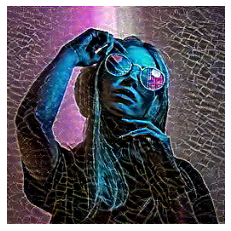

In [ ]:
show_image(model()[0].clip(0, 1));

Comparing to the original:

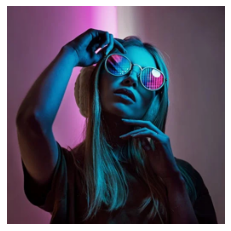

In [ ]:
show_image(content_img.squeeze().clip(0, 1));